<a href="https://colab.research.google.com/github/Arif111866/Deep-Learning-AI/blob/main/Assignment_13/DNN_assignment_13_faces_using_CycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libraries and Setup

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow import keras
from tensorflow.keras import layers
import cv2
from PIL import Image
import zipfile
import requests
from sklearn.model_selection import train_test_split
import random
import glob

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)


TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#dataset download


In [5]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")
path1=path
print("Dataset path -----:", path)
import os
print(os.listdir(path))
import kagglehub

# Download latest version
path2 = kagglehub.dataset_download("heyitsfahd/paintings")

print("Path to dataset files:", path)

Dataset path -----: /kaggle/input/celeba-dataset
['list_landmarks_align_celeba.csv', 'img_align_celeba', 'list_eval_partition.csv', 'list_attr_celeba.csv', 'list_bbox_celeba.csv']


100%|██████████| 21.2M/21.2M [00:00<00:00, 160MB/s]

Extracting files...


Path to dataset files: /kaggle/input/celeba-dataset


#onfiguration and Hyperparameters

In [6]:
class Config:
    IMG_HEIGHT = 64
    IMG_WIDTH = 64
    IMG_CHANNELS = 3

    BATCH_SIZE = 32
    EPOCHS = 40
    LEARNING_RATE = 2e-4
    BETA_1 = 0.5

    LAMBDA_CYCLE = 10.0
    LAMBDA_IDENTITY = 0.5

    CELEBA_PATH = path1 + "/img_align_celeba/img_align_celeba"
    PAINTINGS_PATH = path2 + "/paintings"

    CHECKPOINT_PATH = "/content/checkpoints"

config = Config()



#Data Loading and Preprocessing Functions

In [7]:
def verify_datasets():
    print("Verifying dataset paths...")
    celeba_files = glob.glob(f"{config.CELEBA_PATH}/*.jpg")
    print(f"Found {len(celeba_files)} CelebA images")
    if len(celeba_files) == 0:
        print("Error: No JPG files found in CelebA path!")
        print("Current CelebA path:", config.CELEBA_PATH)
        print("Files in directory:", os.listdir(config.CELEBA_PATH)[:10])

    painting_files = glob.glob(f"{config.PAINTINGS_PATH}/*.jpg")
    print(f"Found {len(painting_files)} painting images")
    return len(celeba_files) > 0 and len(painting_files) > 0

def preprocess_image(image_path, target_size=(64, 64)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, target_size)
    image = (image / 127.5) - 1.0
    return image

def load_dataset(face_dir, painting_dir, batch_size=4):
    face_files = tf.data.Dataset.list_files(f"{face_dir}/*.jpg", shuffle=True)
    painting_files = tf.data.Dataset.list_files(f"{painting_dir}/*.jpg", shuffle=True)

    face_dataset = face_files.map(
        lambda x: preprocess_image(x, (64, 64)),
        num_parallel_calls=tf.data.AUTOTUNE
    ).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    painting_dataset = painting_files.map(
        lambda x: preprocess_image(x, (64, 64)),
        num_parallel_calls=tf.data.AUTOTUNE
    ).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return face_dataset, painting_dataset


#Generator Architecture (With Instance Norm)

In [8]:
class InstanceNormalization(layers.Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        self.scale = self.add_weight(name='scale', shape=input_shape[-1:], initializer='ones', trainable=True)
        self.offset = self.add_weight(name='offset', shape=input_shape[-1:], initializer='zeros', trainable=True)
        super(InstanceNormalization, self).build(input_shape)

    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    if apply_instancenorm:
        result.add(InstanceNormalization())
    result.add(layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    result.add(InstanceNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

def residual_block(filters):
    initializer = tf.random_normal_initializer(0., 0.02)
    def apply(x):
        input_x = x
        x = layers.Conv2D(filters, 3, padding='same', kernel_initializer=initializer, use_bias=False)(x)
        x = InstanceNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(filters, 3, padding='same', kernel_initializer=initializer, use_bias=False)(x)
        x = InstanceNormalization()(x)
        return layers.Add()([input_x, x])
    return apply

def Generator():
    inputs = layers.Input(shape=[64, 64, 3])
    x = layers.Conv2D(32, 7, padding='same', use_bias=False)(inputs)
    x = InstanceNormalization()(x)
    x = layers.ReLU()(x)
    x = downsample(64, 3)(x)
    x = downsample(128, 3)(x)
    for _ in range(6):
        x = residual_block(128)(x)
    x = upsample(64, 3)(x)
    x = upsample(32, 3)(x)
    x = layers.Conv2D(3, 7, padding='same', kernel_initializer=tf.random_normal_initializer(0., 0.02))(x)
    x = layers.Activation('tanh')(x)
    return tf.keras.Model(inputs=inputs, outputs=x)


#Discriminator Architecture

In [9]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = layers.Input(shape=[64, 64, 3])
    x = downsample(32, 4, False)(inp)
    x = downsample(64, 4)(x)
    x = downsample(128, 4)(x)
    x = layers.ZeroPadding2D()(x)
    x = layers.Conv2D(256, 4, kernel_initializer=initializer, use_bias=False)(x)
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.ZeroPadding2D()(x)
    x = layers.Conv2D(1, 4, kernel_initializer=initializer)(x)
    return tf.keras.Model(inputs=inp, outputs=x)


#Loss Functions

In [10]:
def discriminator_loss(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(
        tf.ones_like(real), real)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(
        tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(
        tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return config.LAMBDA_CYCLE * loss1

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return config.LAMBDA_IDENTITY * 0.5 * loss


#Model Initialization and Optimizers

In [11]:
# Initialize models
generator_g = Generator()  # Face to Painting
generator_f = Generator()  # Painting to Face
discriminator_x = Discriminator()  # Face discriminator
discriminator_y = Discriminator()  # Painting discriminator

# Optimizers
generator_g_optimizer = tf.keras.optimizers.Adam(config.LEARNING_RATE, beta_1=config.BETA_1)
generator_f_optimizer = tf.keras.optimizers.Adam(config.LEARNING_RATE, beta_1=config.BETA_1)
discriminator_x_optimizer = tf.keras.optimizers.Adam(config.LEARNING_RATE, beta_1=config.BETA_1)
discriminator_y_optimizer = tf.keras.optimizers.Adam(config.LEARNING_RATE, beta_1=config.BETA_1)

print("Models initialized successfully!")


Models initialized successfully!


#Training Step Function

In [12]:
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
        total_identity_loss = identity_loss(real_y, same_y) + identity_loss(real_x, same_x)

        total_gen_g_loss = gen_g_loss + total_cycle_loss + total_identity_loss
        total_gen_f_loss = gen_f_loss + total_cycle_loss + total_identity_loss

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

    return {
        'gen_g_loss': total_gen_g_loss,
        'gen_f_loss': total_gen_f_loss,
        'disc_x_loss': disc_x_loss,
        'disc_y_loss': disc_y_loss,
        'cycle_loss': total_cycle_loss,
        'identity_loss': total_identity_loss
    }


# Visualization Utilitie

In [17]:
def generate_images(model, test_input, id, save_path=None):
    prediction = model(test_input)
    plt.figure(figsize=(12, 4))

    display_list = [test_input[id], prediction[id]]
    title = ['Input Image', 'Generated Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')

    if save_path:
        plt.savefig(save_path)
    plt.show()

def save_model_weights(epoch):
    os.makedirs(config.CHECKPOINT_PATH, exist_ok=True)
    generator_g.save_weights(f"{config.CHECKPOINT_PATH}/gen_g_epoch_{epoch}.weights.h5")
    generator_f.save_weights(f"{config.CHECKPOINT_PATH}/gen_f_epoch_{epoch}.weights.h5")
    discriminator_x.save_weights(f"{config.CHECKPOINT_PATH}/disc_x_epoch_{epoch}.weights.h5")
    discriminator_y.save_weights(f"{config.CHECKPOINT_PATH}/disc_y_epoch_{epoch}.weights.h5")

#Training Loop

In [20]:
def train_cyclegan(face_dataset, painting_dataset, epochs):
    os.makedirs(config.CHECKPOINT_PATH, exist_ok=True)
    os.makedirs("generated_samples", exist_ok=True)

    fixed_face = next(iter(face_dataset.take(1)))
    fixed_painting = next(iter(painting_dataset.take(1)))

    history = {
        'gen_g_loss': [],
        'gen_f_loss': [],
        'disc_x_loss': [],
        'disc_y_loss': [],
        'cycle_loss': [],
        'identity_loss': []
    }

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        gen_g_loss_avg = tf.keras.metrics.Mean()
        gen_f_loss_avg = tf.keras.metrics.Mean()
        disc_x_loss_avg = tf.keras.metrics.Mean()
        disc_y_loss_avg = tf.keras.metrics.Mean()
        cycle_loss_avg = tf.keras.metrics.Mean()
        identity_loss_avg = tf.keras.metrics.Mean()

        for step, (real_x, real_y) in enumerate(zip(face_dataset, painting_dataset)):
            if step >= 500:
                break
            losses = train_step(real_x, real_y)
            gen_g_loss_avg.update_state(losses['gen_g_loss'])
            gen_f_loss_avg.update_state(losses['gen_f_loss'])
            disc_x_loss_avg.update_state(losses['disc_x_loss'])
            disc_y_loss_avg.update_state(losses['disc_y_loss'])
            cycle_loss_avg.update_state(losses['cycle_loss'])
            identity_loss_avg.update_state(losses['identity_loss'])

        history['gen_g_loss'].append(gen_g_loss_avg.result().numpy())
        history['gen_f_loss'].append(gen_f_loss_avg.result().numpy())
        history['disc_x_loss'].append(disc_x_loss_avg.result().numpy())
        history['disc_y_loss'].append(disc_y_loss_avg.result().numpy())
        history['cycle_loss'].append(cycle_loss_avg.result().numpy())
        history['identity_loss'].append(identity_loss_avg.result().numpy())

        print(f"Gen_G: {history['gen_g_loss'][-1]:.4f}, "
              f"Gen_F: {history['gen_f_loss'][-1]:.4f}, "
              f"Disc_X: {history['disc_x_loss'][-1]:.4f}, "
              f"Disc_Y: {history['disc_y_loss'][-1]:.4f}")

        generate_images(generator_g, fixed_face, 0, f"generated_samples/face_to_painting_epoch_{epoch + 1}.png")
        generate_images(generator_f, fixed_painting, 0, f"generated_samples/painting_to_face_epoch_{epoch + 1}.png")

        if (epoch + 1) % 10 == 0:
            save_model_weights(epoch + 1)

    return history

#Data Loading and Training Execution

Loading datasets...
Starting training...

Epoch 1/40
Gen_G: 5.3624, Gen_F: 5.5159, Disc_X: 0.5587, Disc_Y: 0.6089


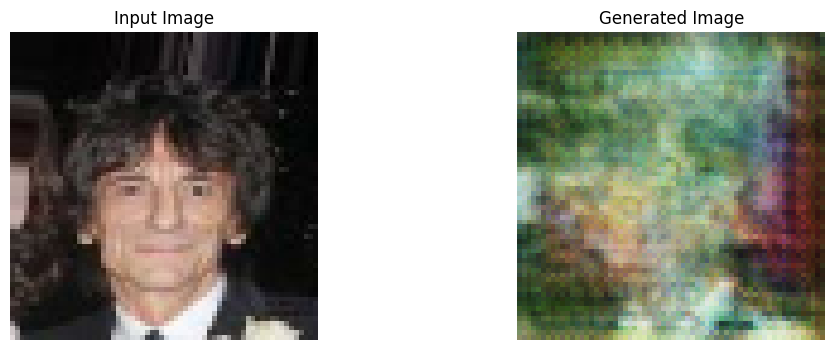

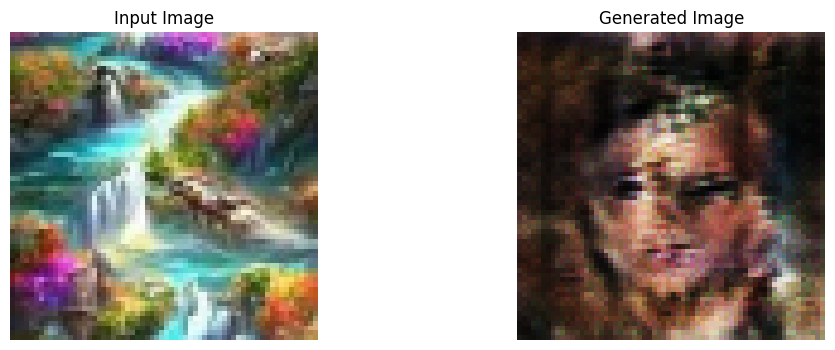


Epoch 2/40
Gen_G: 5.2469, Gen_F: 5.4152, Disc_X: 0.5317, Disc_Y: 0.6051


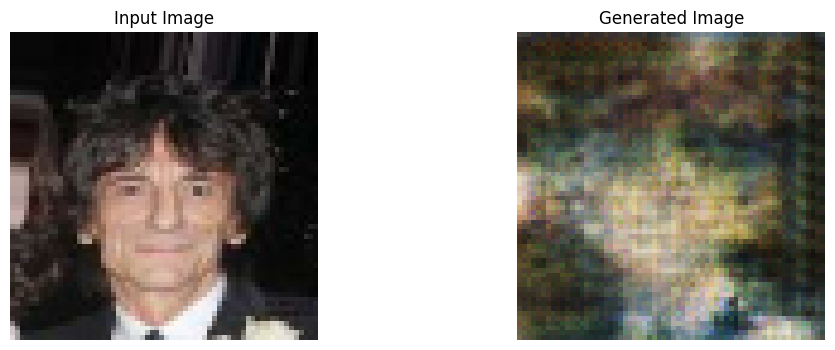

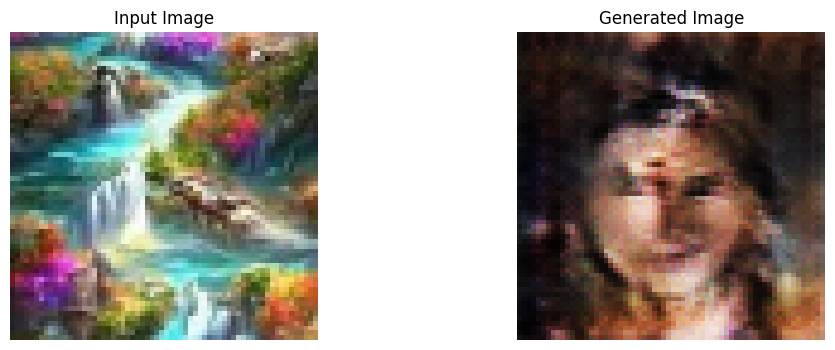


Epoch 3/40
Gen_G: 5.1820, Gen_F: 5.3539, Disc_X: 0.5485, Disc_Y: 0.6160


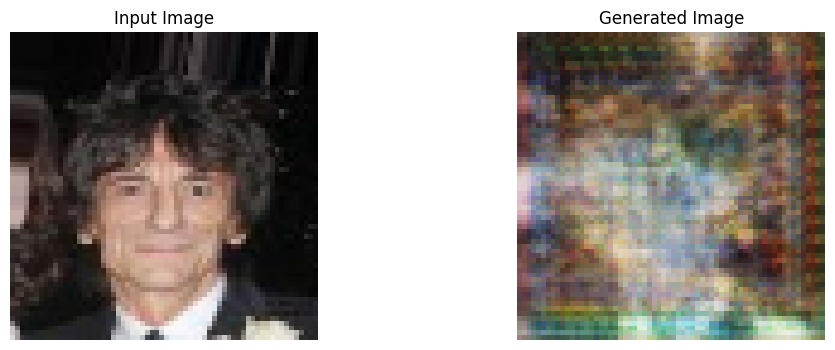

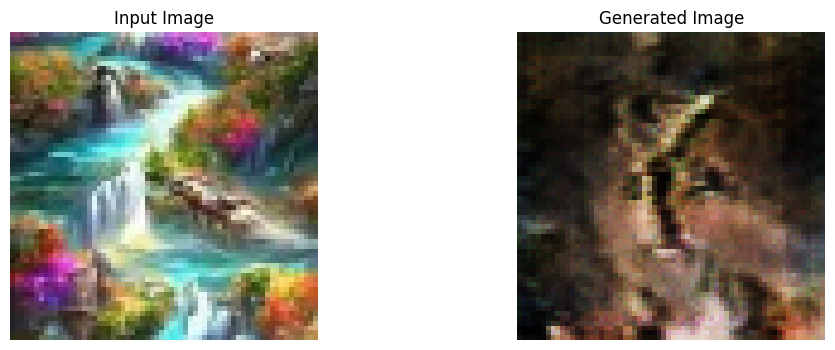


Epoch 4/40
Gen_G: 5.1429, Gen_F: 5.3281, Disc_X: 0.5557, Disc_Y: 0.6155


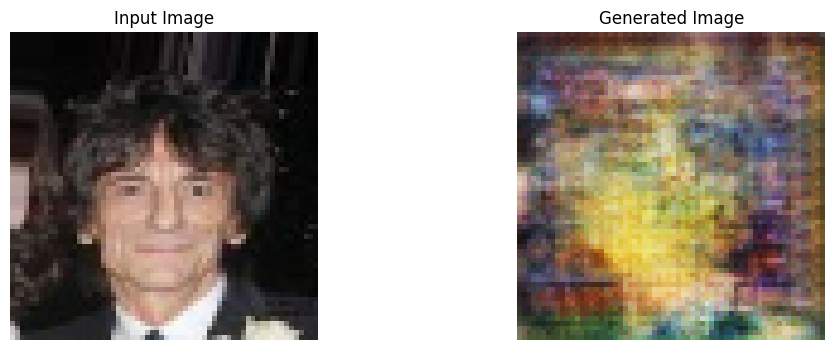

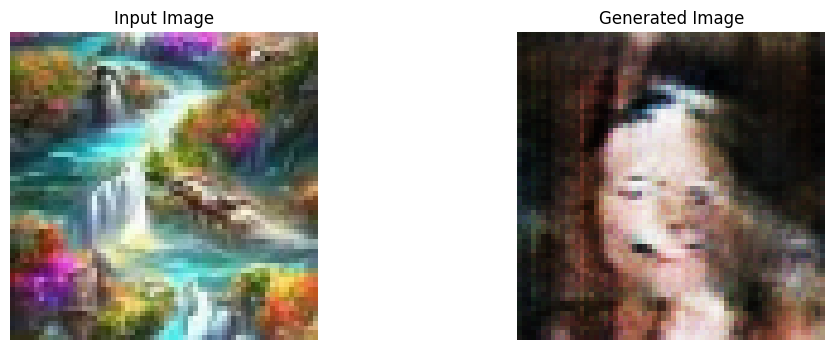


Epoch 5/40
Gen_G: 5.1291, Gen_F: 5.3697, Disc_X: 0.5373, Disc_Y: 0.6186


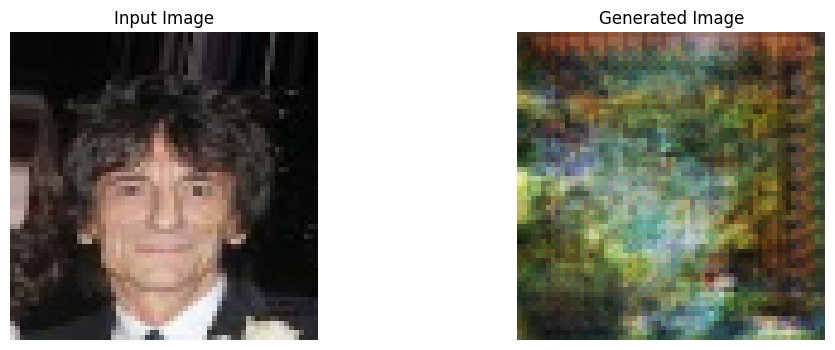

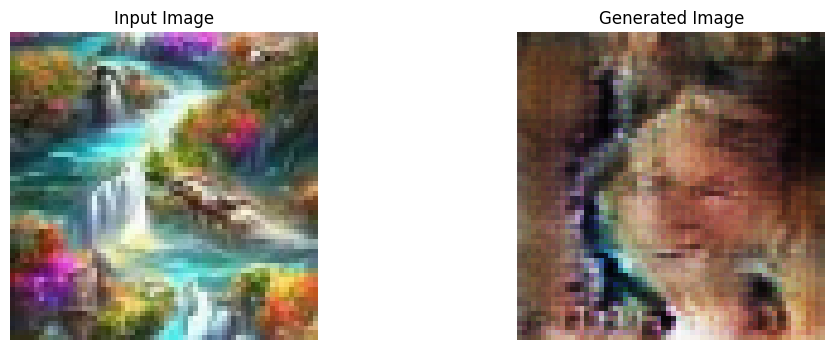


Epoch 6/40
Gen_G: 5.0862, Gen_F: 5.2884, Disc_X: 0.5407, Disc_Y: 0.6160


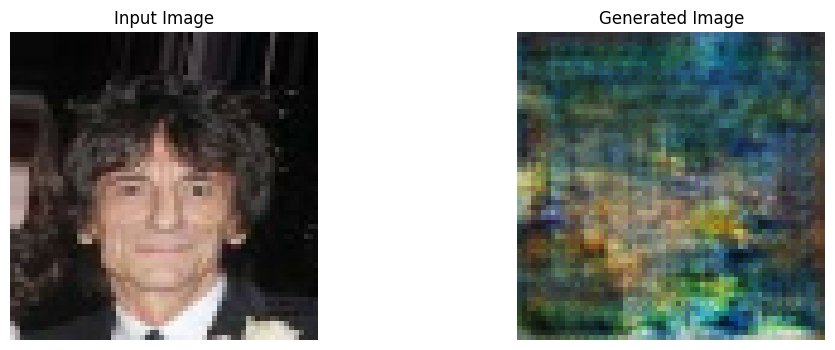

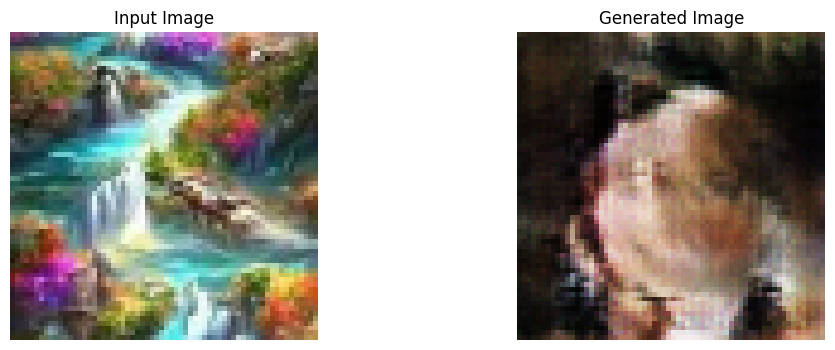


Epoch 7/40
Gen_G: 5.0108, Gen_F: 5.2186, Disc_X: 0.5483, Disc_Y: 0.6115


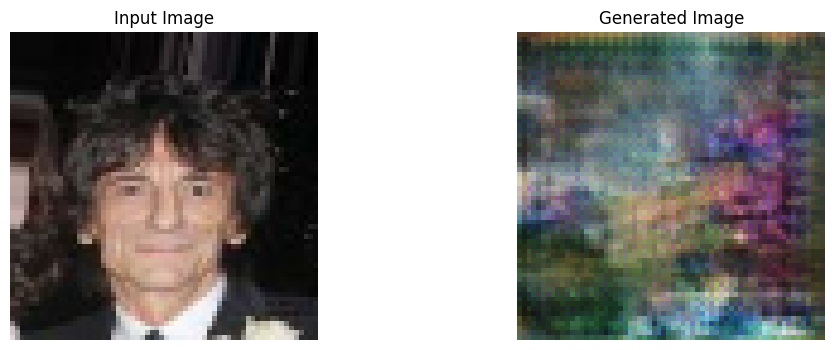

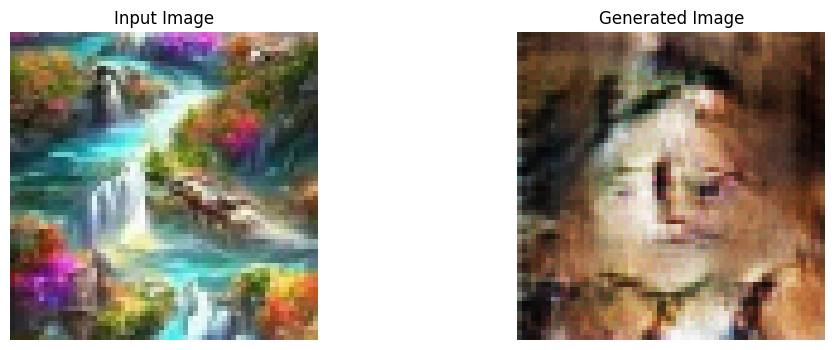


Epoch 8/40
Gen_G: 4.9341, Gen_F: 5.1155, Disc_X: 0.5530, Disc_Y: 0.6162


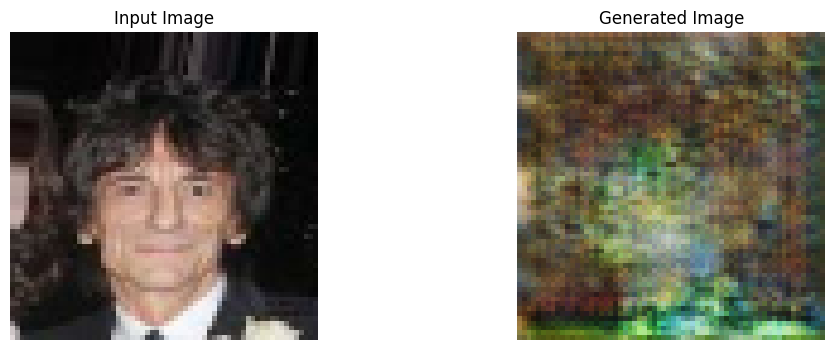

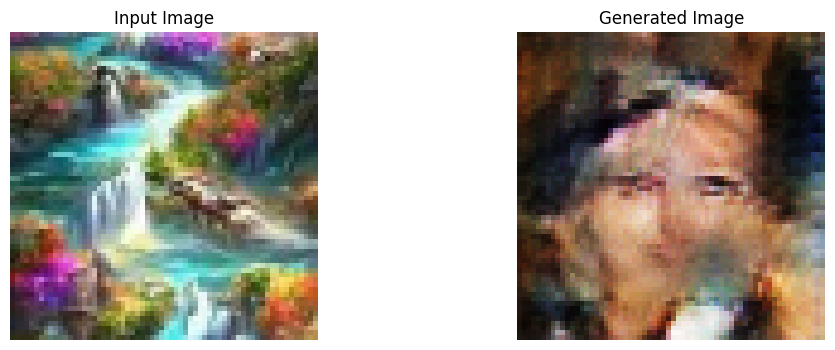


Epoch 9/40
Gen_G: 5.0021, Gen_F: 5.1419, Disc_X: 0.5667, Disc_Y: 0.6019


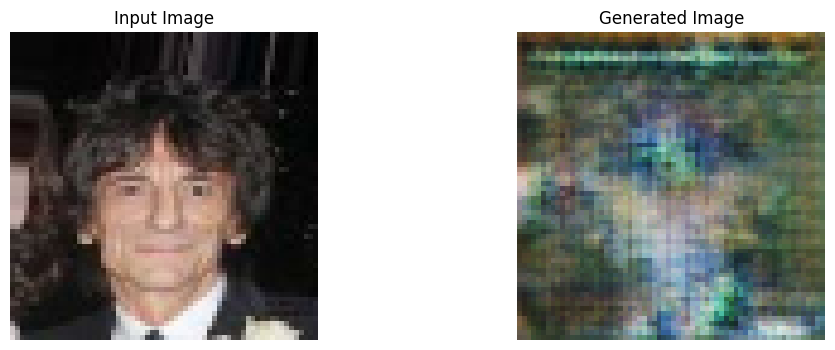

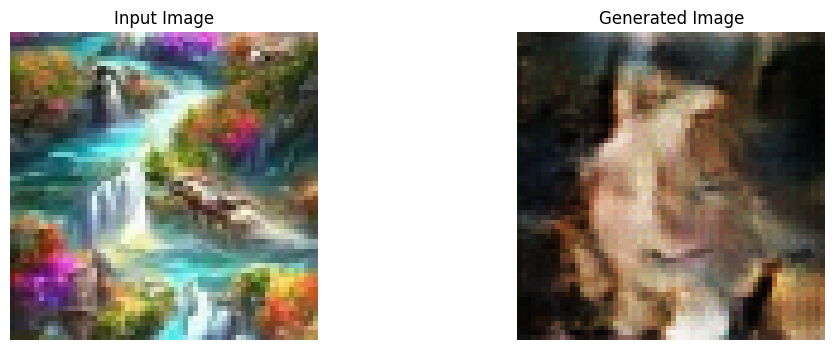


Epoch 10/40
Gen_G: 4.9224, Gen_F: 5.0691, Disc_X: 0.5549, Disc_Y: 0.6025


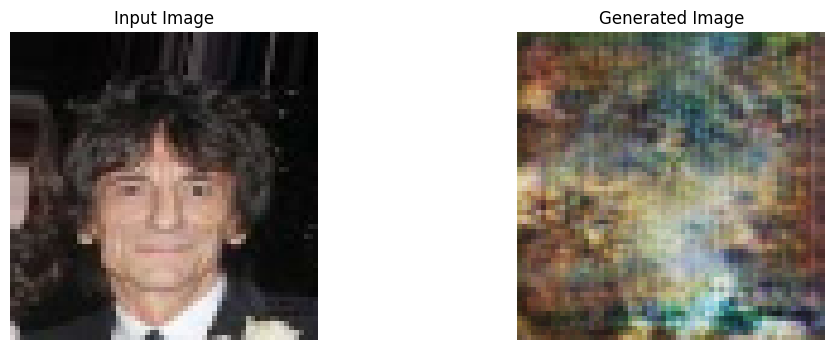

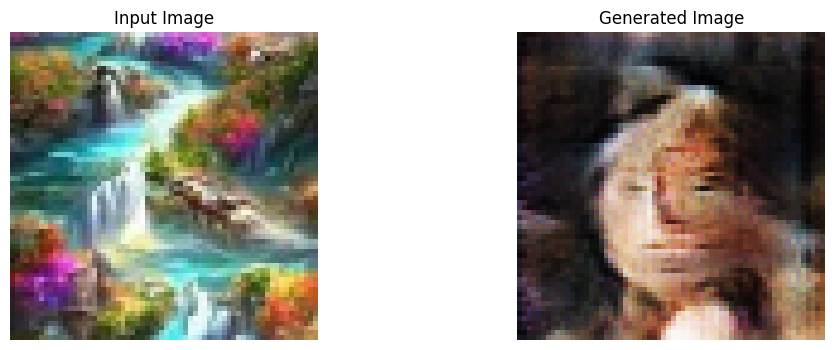


Epoch 11/40
Gen_G: 4.9005, Gen_F: 5.0328, Disc_X: 0.5408, Disc_Y: 0.5983


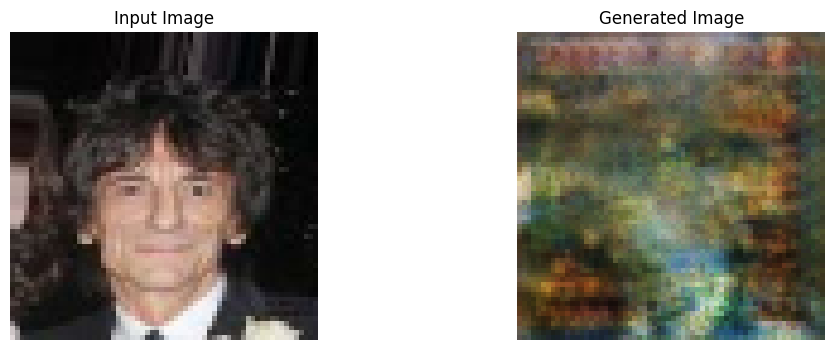

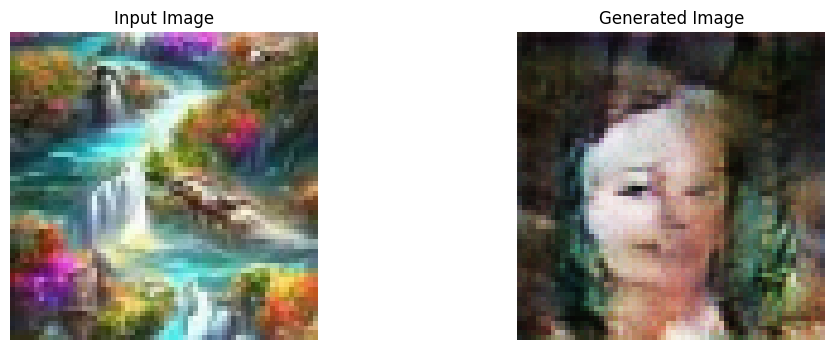


Epoch 12/40
Gen_G: 4.9041, Gen_F: 5.0350, Disc_X: 0.5554, Disc_Y: 0.5855


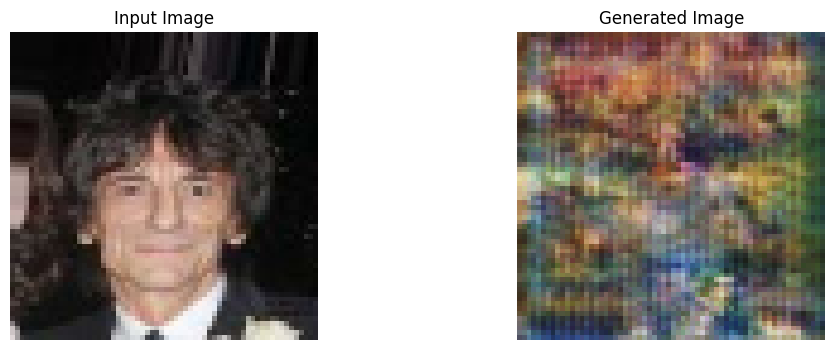

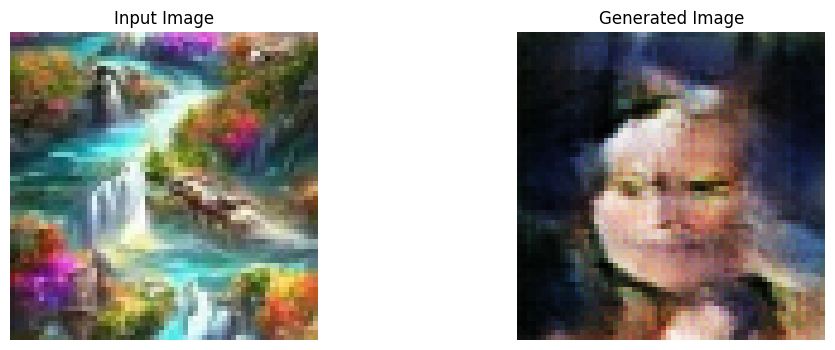


Epoch 13/40
Gen_G: 4.9156, Gen_F: 4.9778, Disc_X: 0.5573, Disc_Y: 0.5799


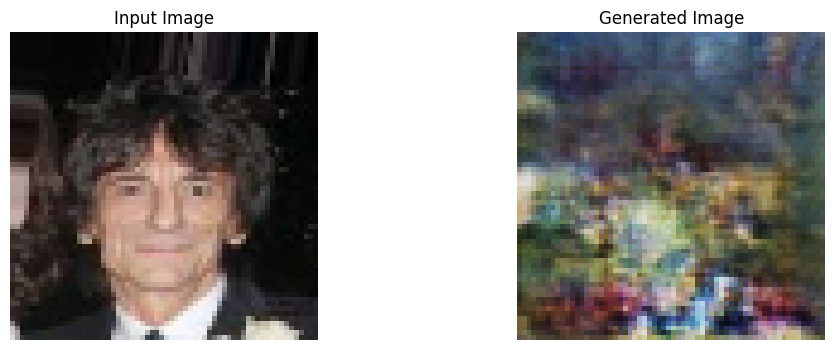

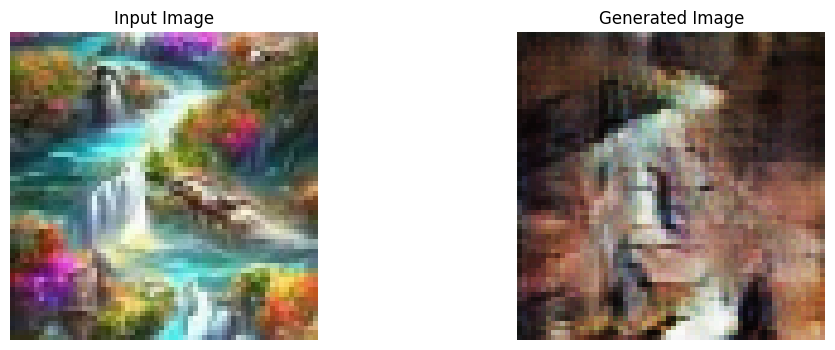


Epoch 14/40
Gen_G: 4.9970, Gen_F: 5.0103, Disc_X: 0.5377, Disc_Y: 0.5447


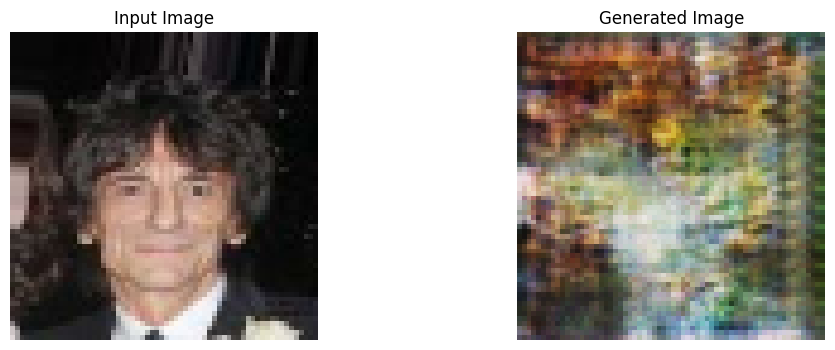

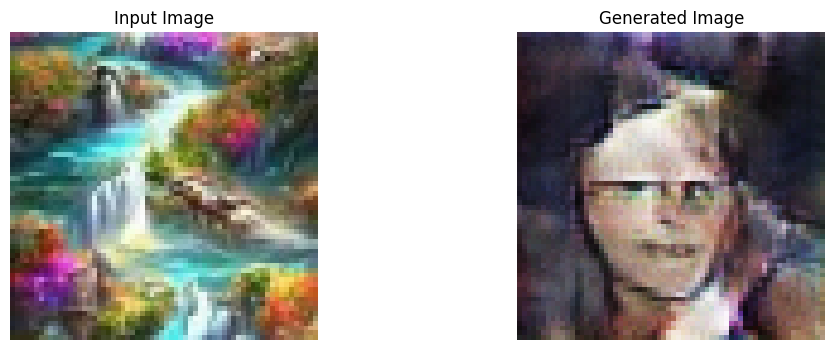


Epoch 15/40
Gen_G: 5.2384, Gen_F: 5.0723, Disc_X: 0.5375, Disc_Y: 0.5264


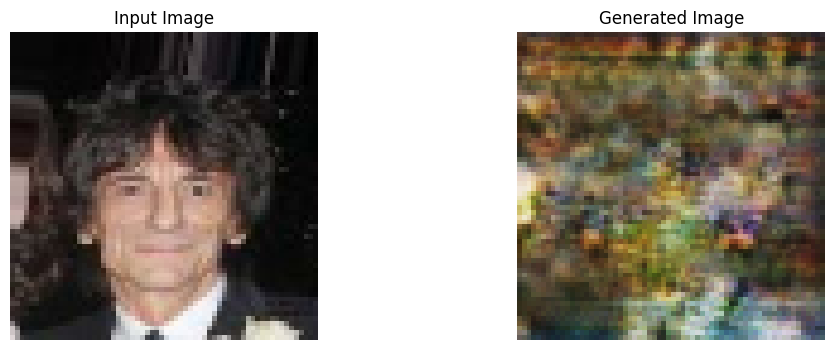

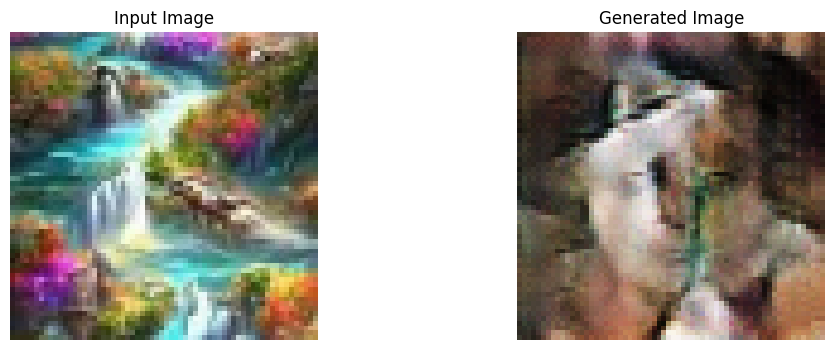


Epoch 16/40
Gen_G: 5.2764, Gen_F: 5.0496, Disc_X: 0.5551, Disc_Y: 0.5076


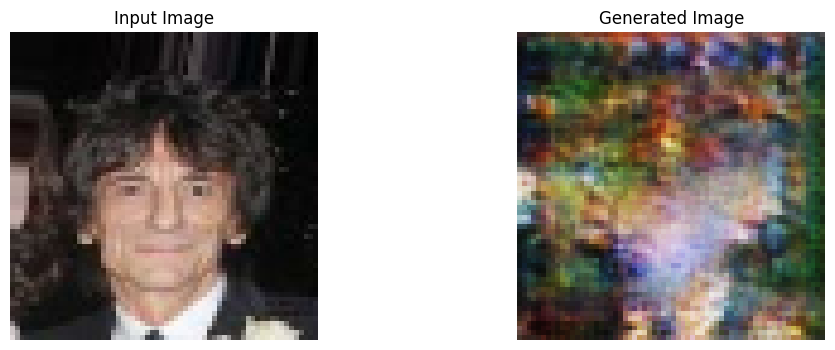

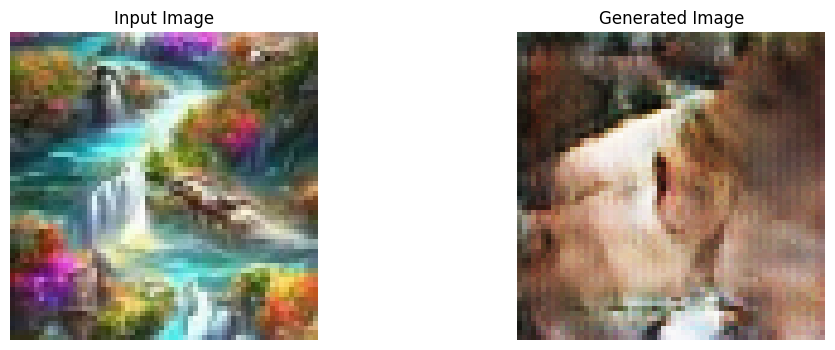


Epoch 17/40
Gen_G: 5.2959, Gen_F: 4.9691, Disc_X: 0.5505, Disc_Y: 0.4759


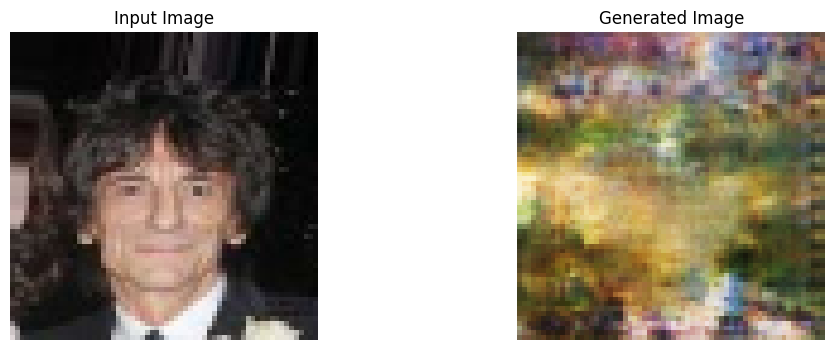

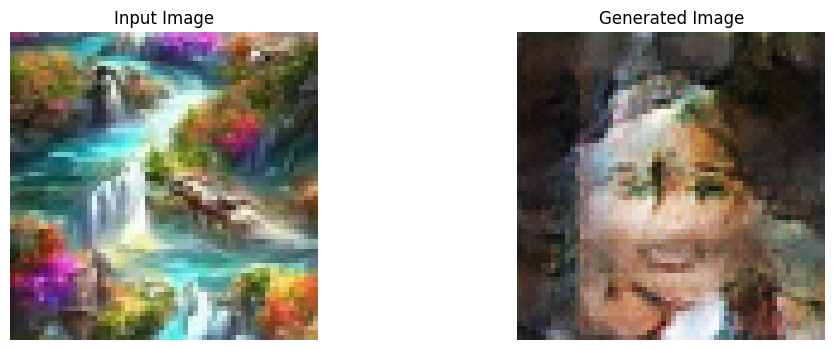


Epoch 18/40
Gen_G: 5.2844, Gen_F: 4.9843, Disc_X: 0.5444, Disc_Y: 0.4846


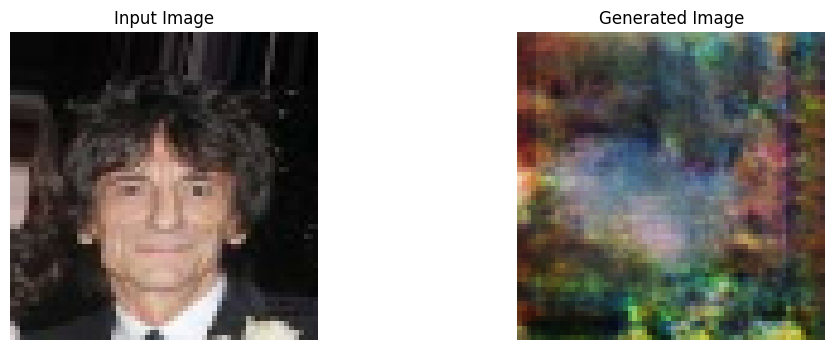

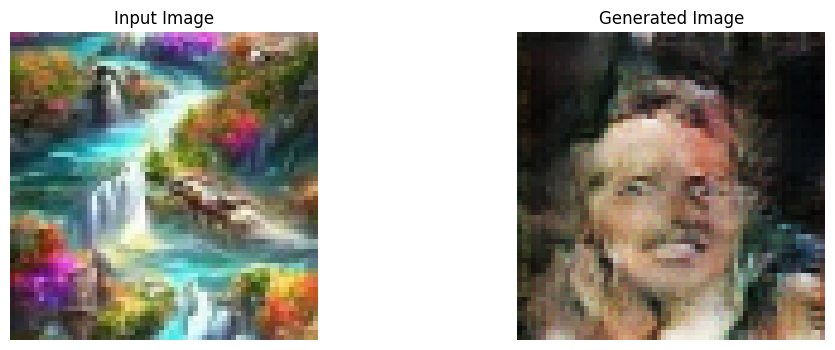


Epoch 19/40
Gen_G: 5.4868, Gen_F: 5.0690, Disc_X: 0.5389, Disc_Y: 0.4507


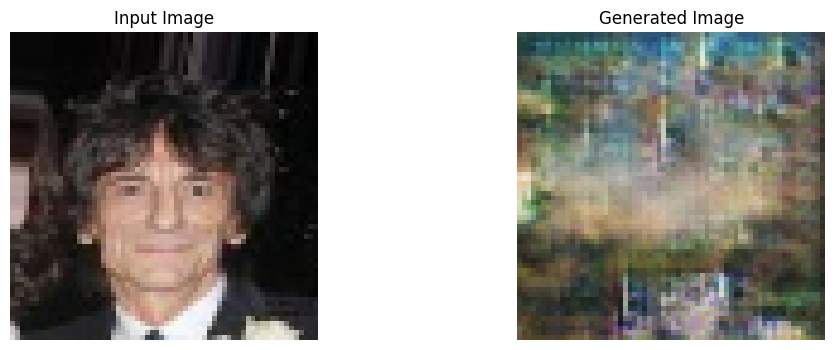

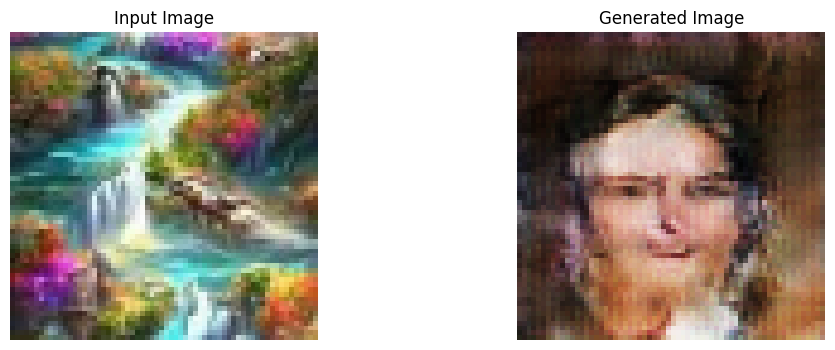


Epoch 20/40
Gen_G: 5.4203, Gen_F: 5.0994, Disc_X: 0.5293, Disc_Y: 0.4600


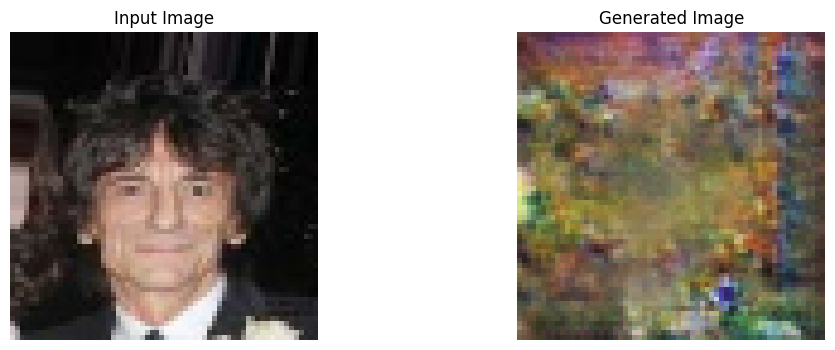

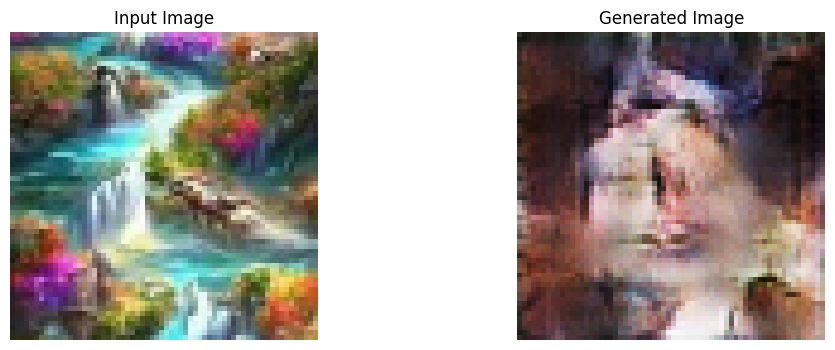


Epoch 21/40
Gen_G: 5.4344, Gen_F: 5.1209, Disc_X: 0.5297, Disc_Y: 0.4601


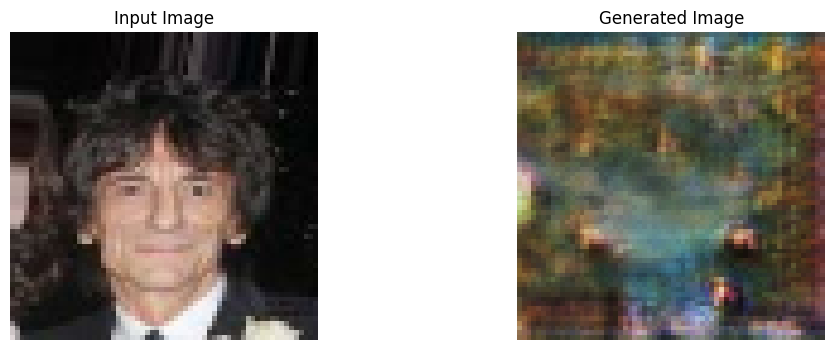

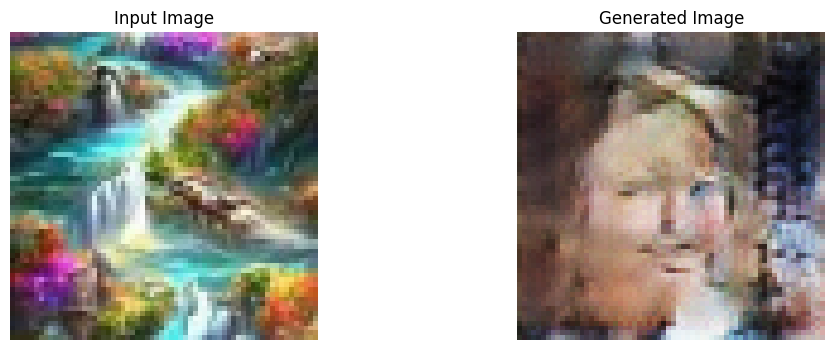


Epoch 22/40
Gen_G: 5.4607, Gen_F: 5.0738, Disc_X: 0.5434, Disc_Y: 0.4503


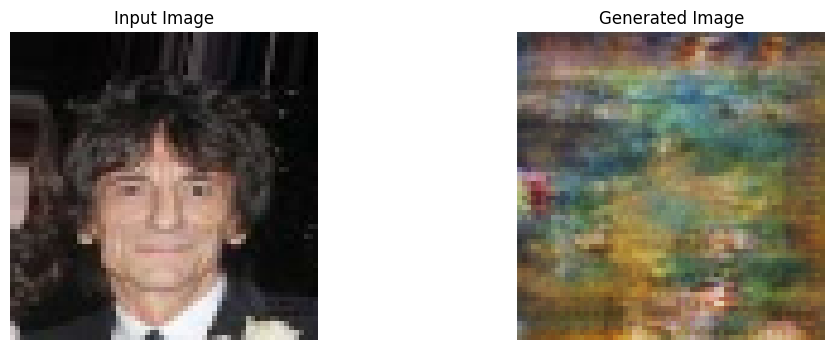

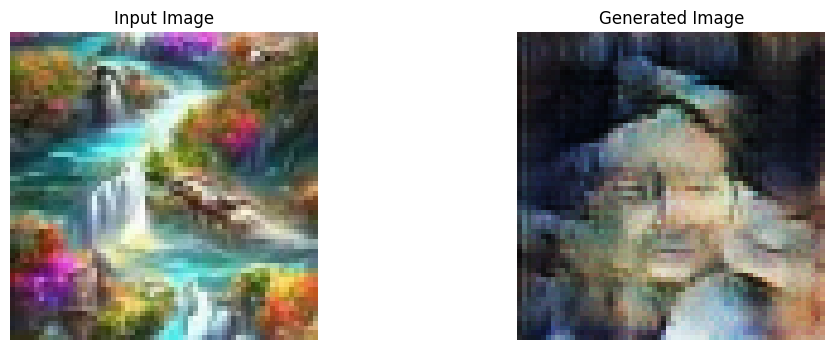


Epoch 23/40
Gen_G: 5.5073, Gen_F: 5.1389, Disc_X: 0.5299, Disc_Y: 0.4379


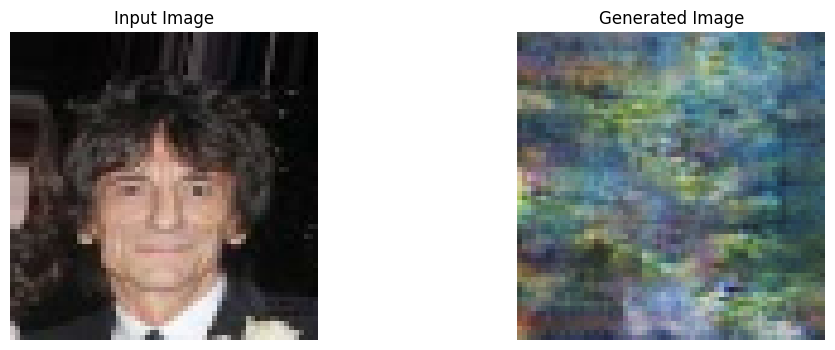

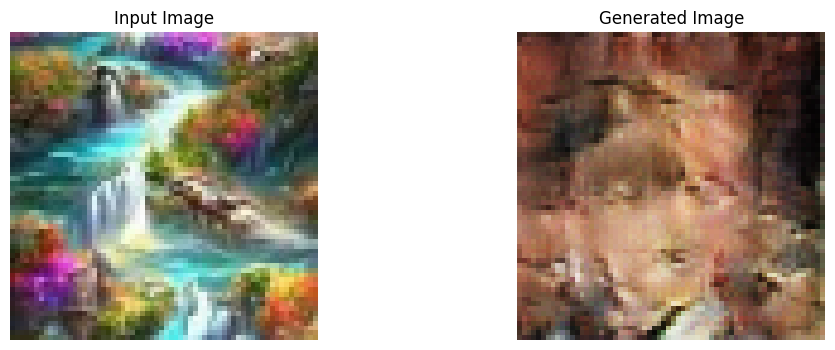


Epoch 24/40
Gen_G: 5.6867, Gen_F: 5.2013, Disc_X: 0.5265, Disc_Y: 0.4386


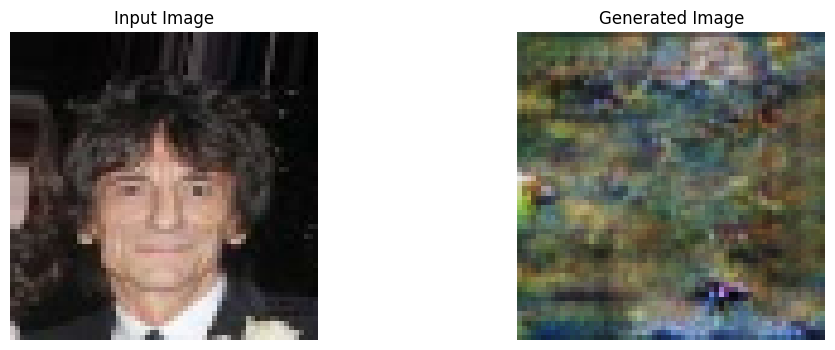

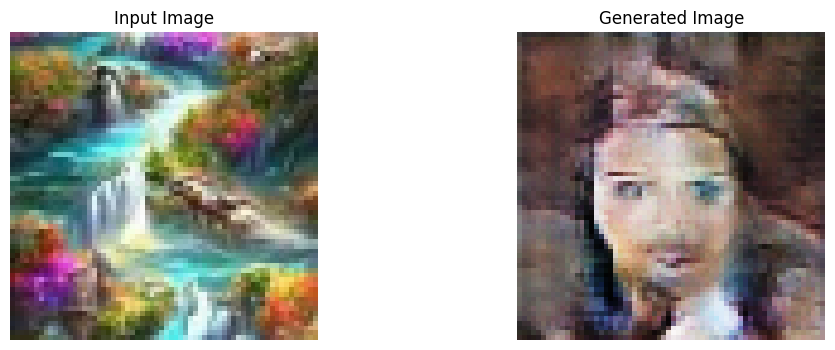


Epoch 25/40
Gen_G: 5.5491, Gen_F: 5.1574, Disc_X: 0.5179, Disc_Y: 0.4278


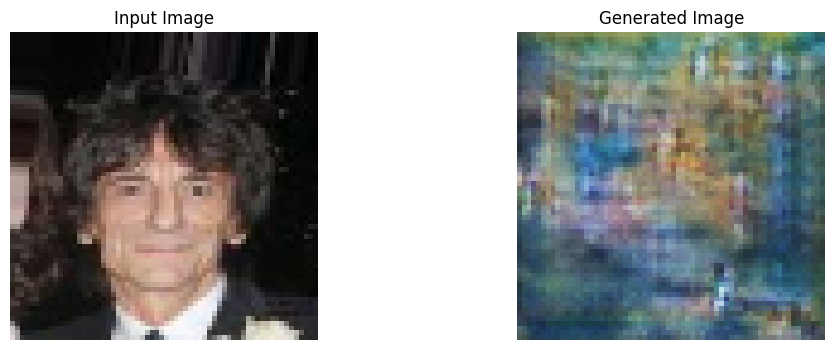

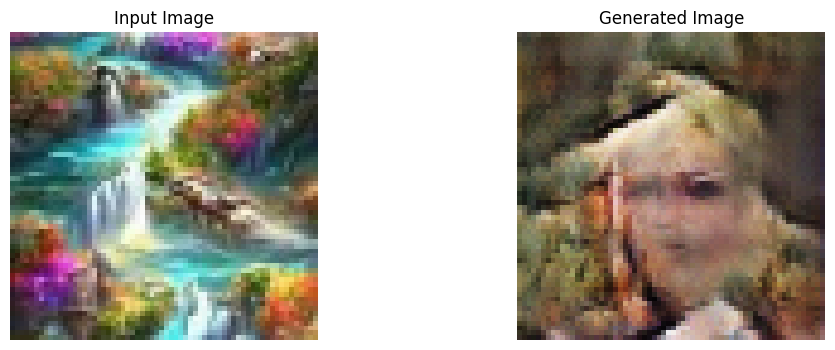


Epoch 26/40
Gen_G: 5.6449, Gen_F: 5.2017, Disc_X: 0.5146, Disc_Y: 0.4448


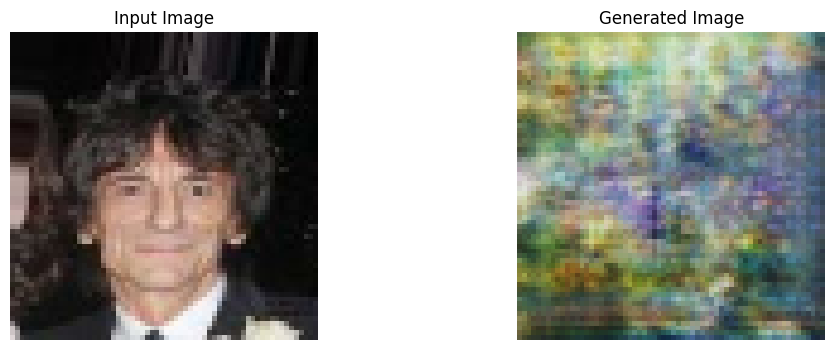

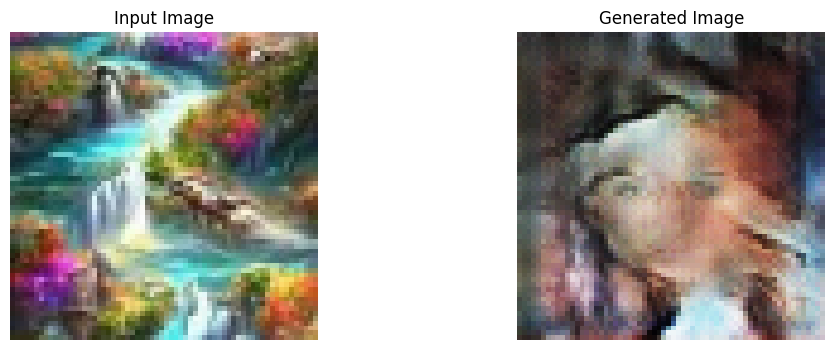


Epoch 27/40
Gen_G: 5.5698, Gen_F: 5.2016, Disc_X: 0.4991, Disc_Y: 0.4428


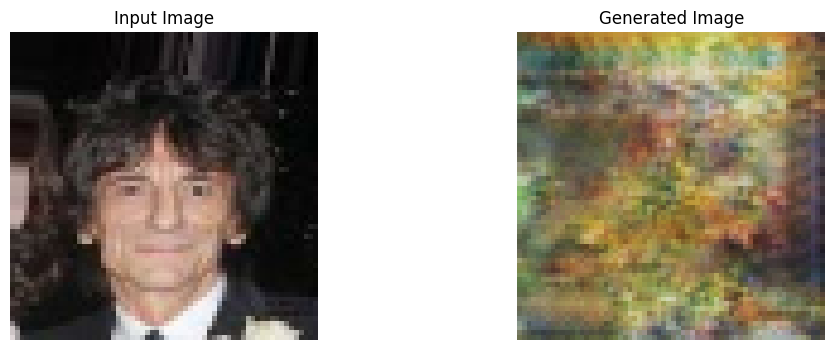

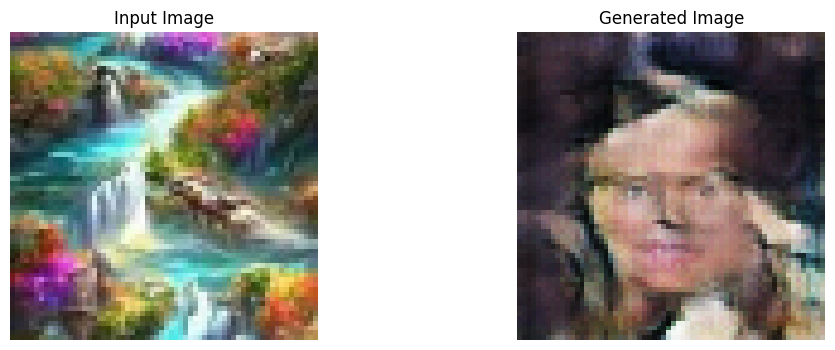


Epoch 28/40
Gen_G: 5.5958, Gen_F: 5.1726, Disc_X: 0.5204, Disc_Y: 0.4225


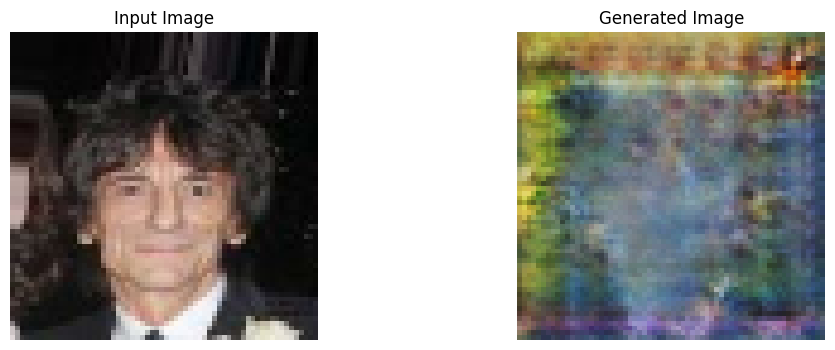

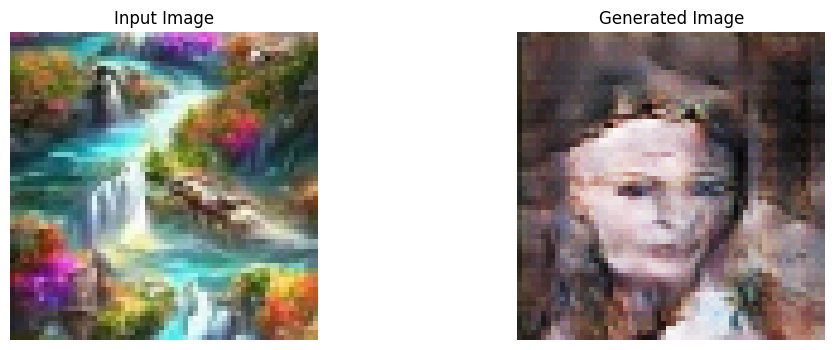


Epoch 29/40
Gen_G: 5.7308, Gen_F: 5.3441, Disc_X: 0.4970, Disc_Y: 0.4217


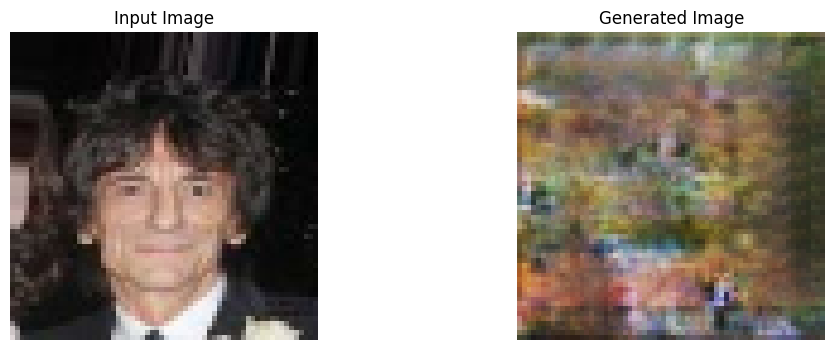

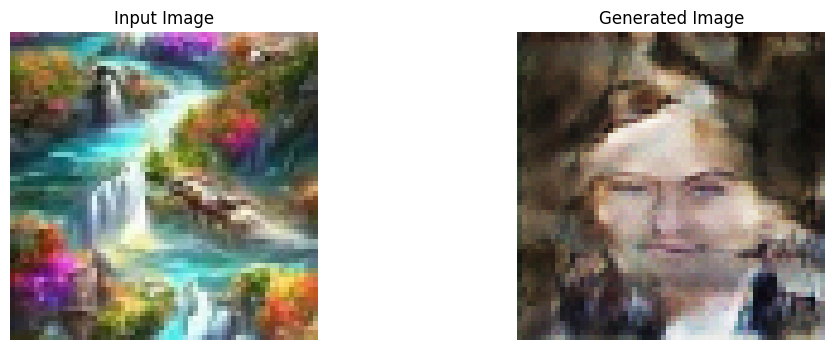


Epoch 30/40
Gen_G: 5.7495, Gen_F: 5.3157, Disc_X: 0.5018, Disc_Y: 0.4086


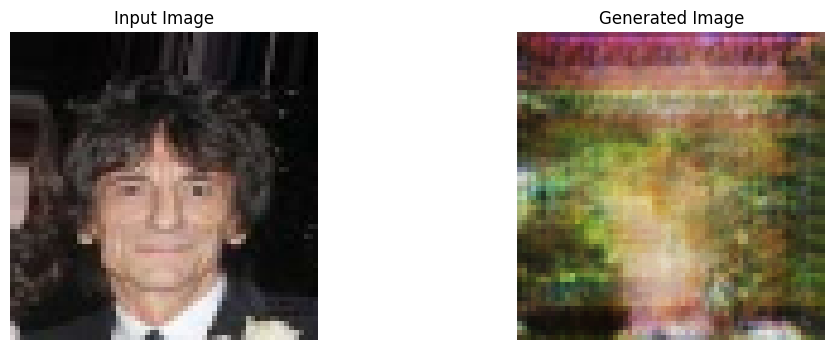

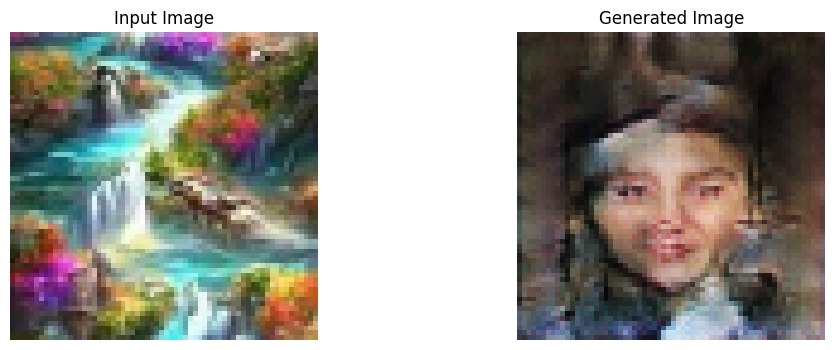


Epoch 31/40
Gen_G: 5.7649, Gen_F: 5.3176, Disc_X: 0.4866, Disc_Y: 0.4138


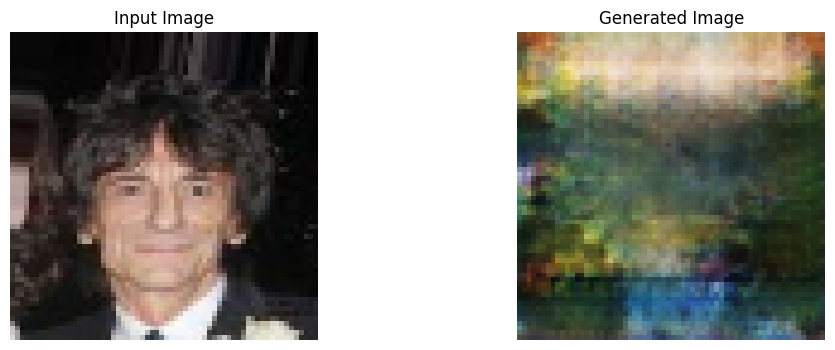

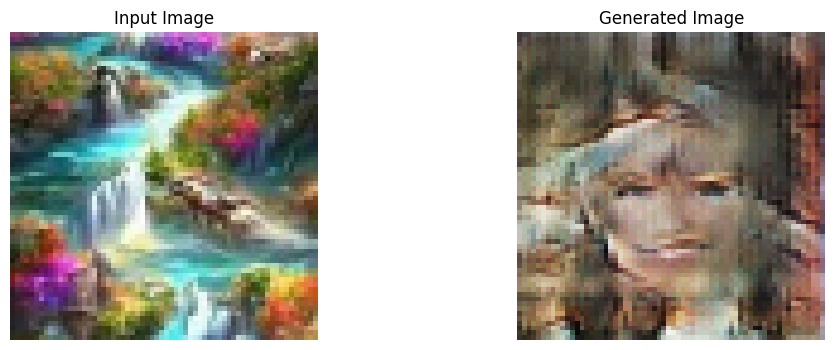


Epoch 32/40
Gen_G: 5.7099, Gen_F: 5.3835, Disc_X: 0.4992, Disc_Y: 0.4157


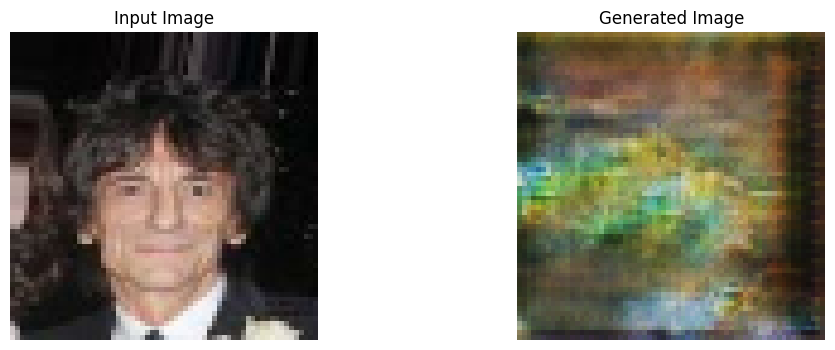

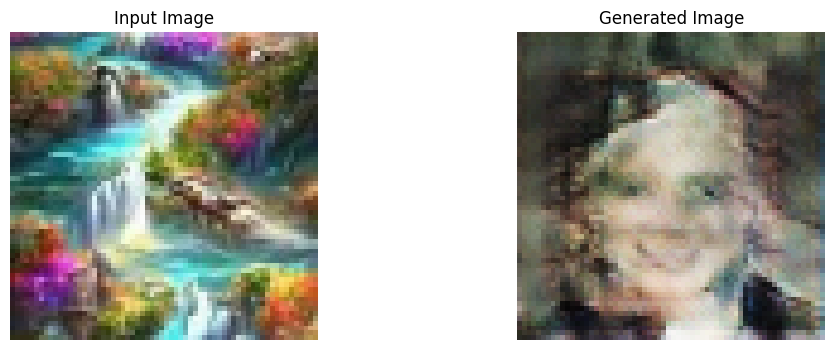


Epoch 33/40
Gen_G: 5.6862, Gen_F: 5.2611, Disc_X: 0.4839, Disc_Y: 0.4061


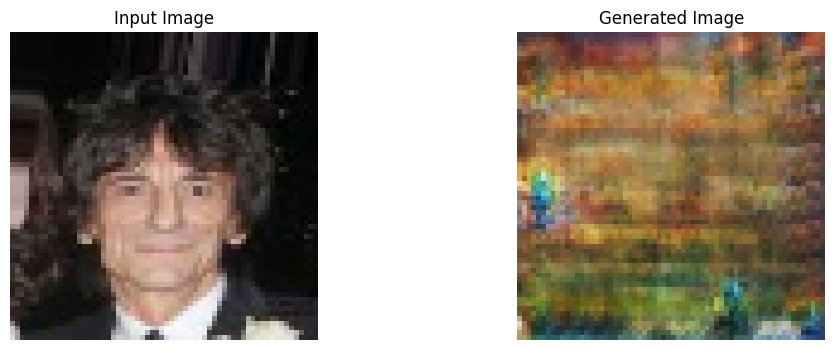

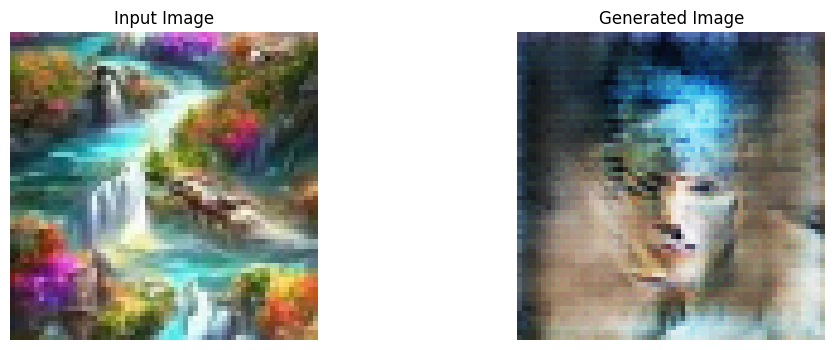


Epoch 34/40
Gen_G: 5.8740, Gen_F: 5.5388, Disc_X: 0.4544, Disc_Y: 0.3831


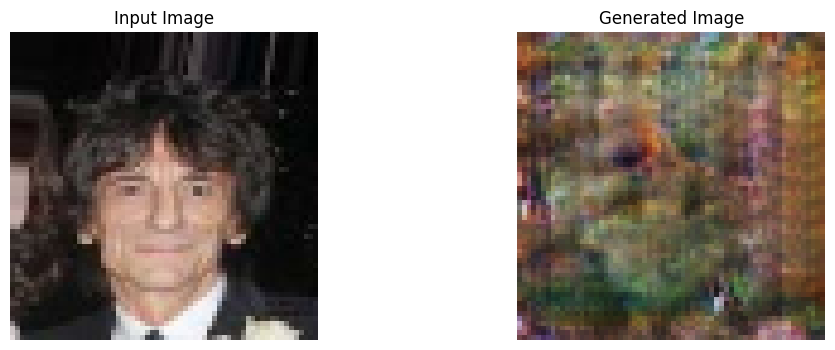

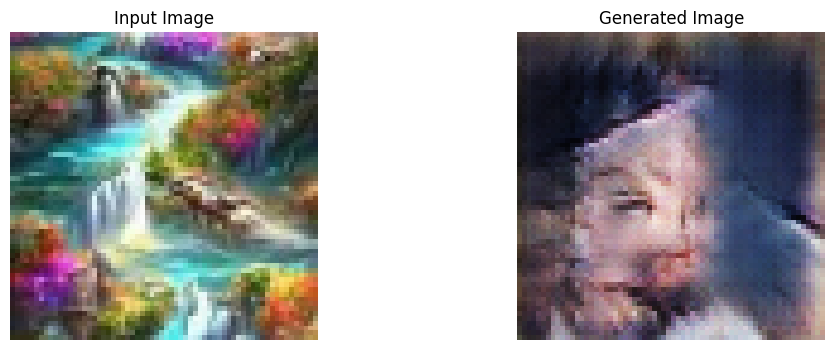


Epoch 35/40
Gen_G: 5.7881, Gen_F: 5.4246, Disc_X: 0.4640, Disc_Y: 0.4157


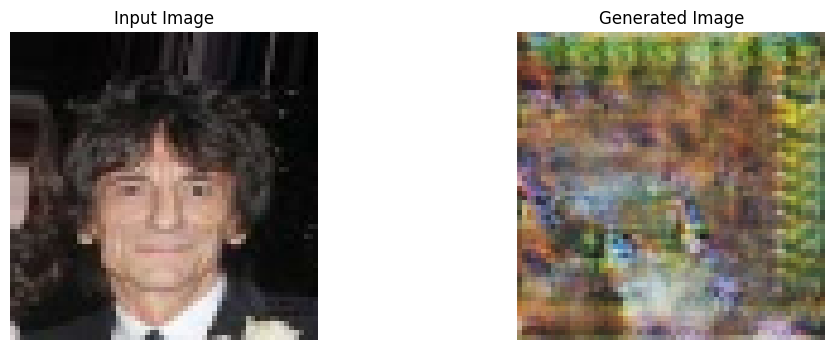

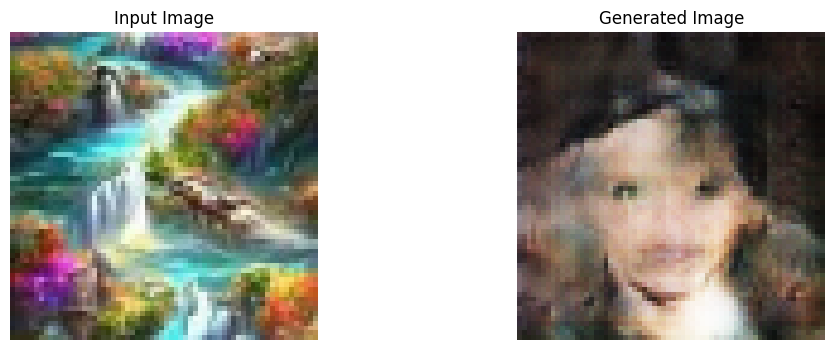


Epoch 36/40
Gen_G: 5.8686, Gen_F: 5.4502, Disc_X: 0.4825, Disc_Y: 0.4119


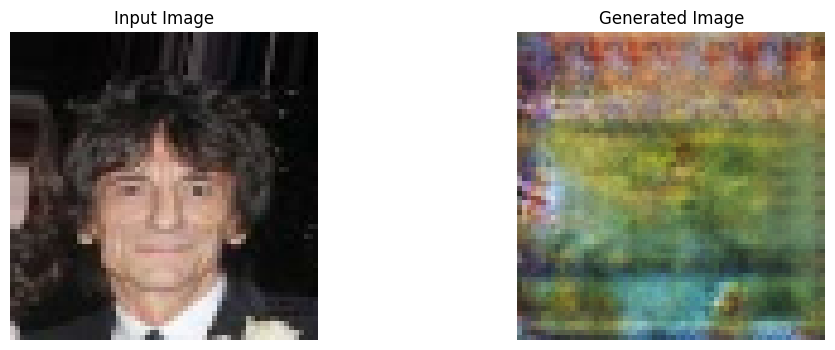

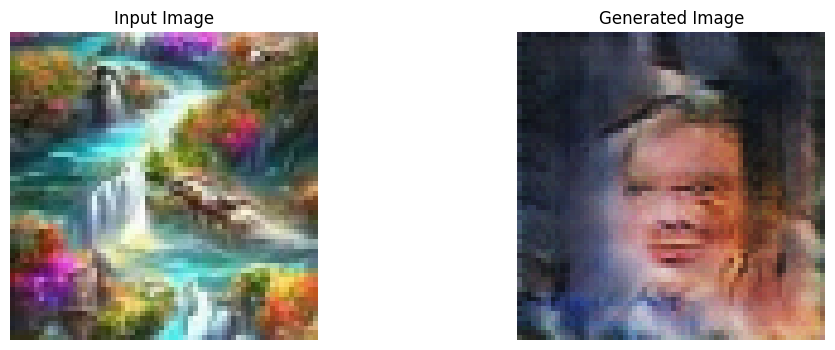


Epoch 37/40
Gen_G: 5.8263, Gen_F: 5.4251, Disc_X: 0.4856, Disc_Y: 0.3978


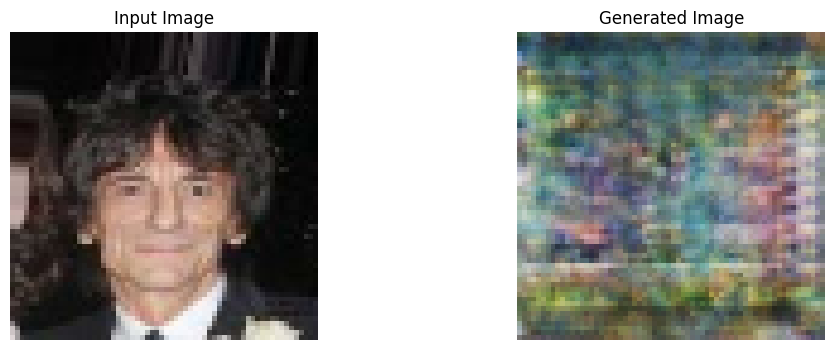

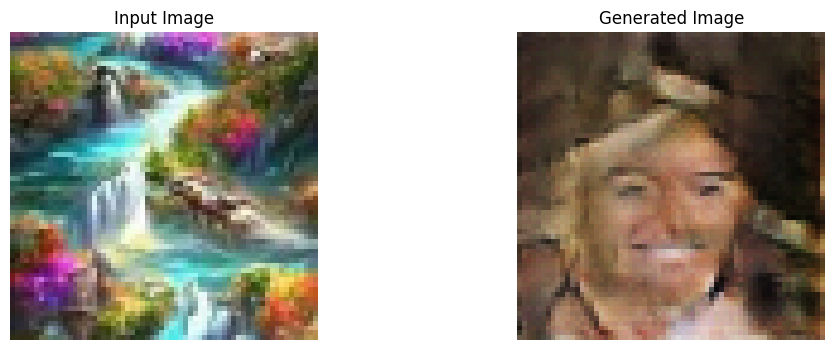


Epoch 38/40
Gen_G: 5.9253, Gen_F: 5.4299, Disc_X: 0.4570, Disc_Y: 0.3968


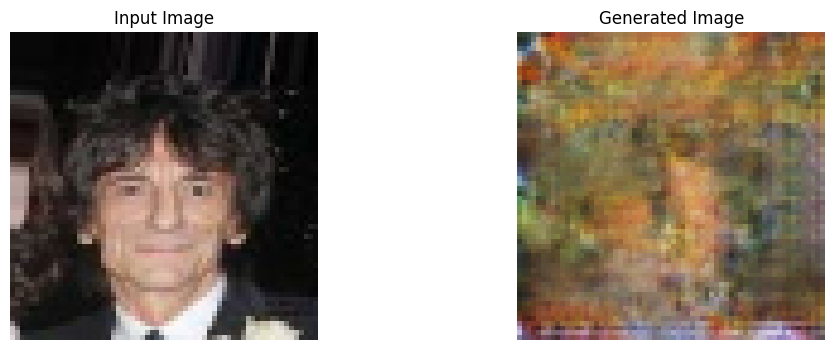

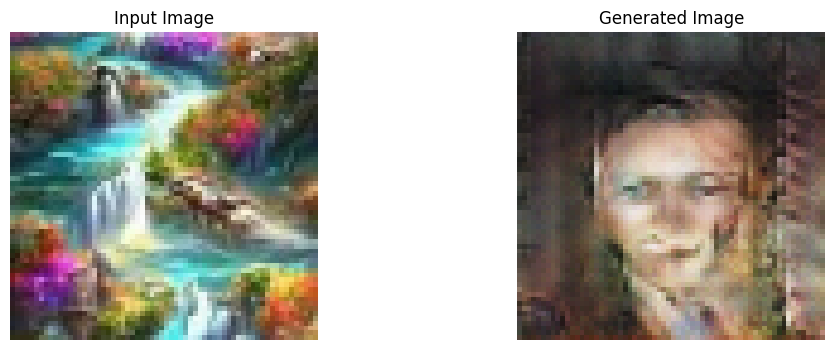


Epoch 39/40
Gen_G: 5.7973, Gen_F: 5.3998, Disc_X: 0.4843, Disc_Y: 0.4157


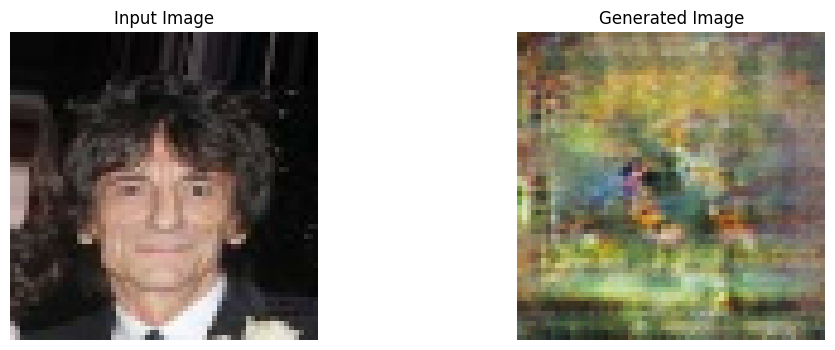

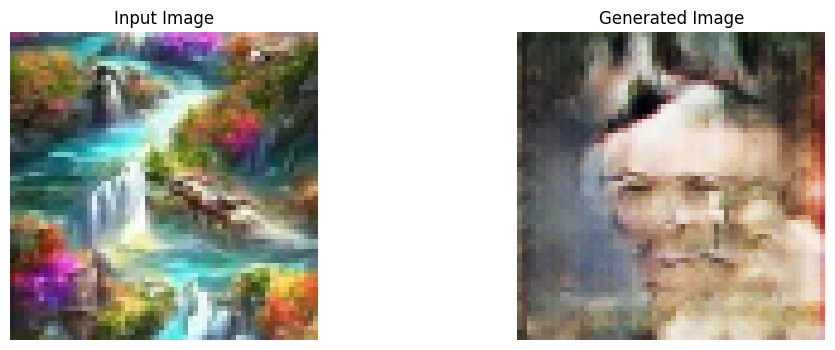


Epoch 40/40
Gen_G: 5.9103, Gen_F: 5.4995, Disc_X: 0.4436, Disc_Y: 0.3918


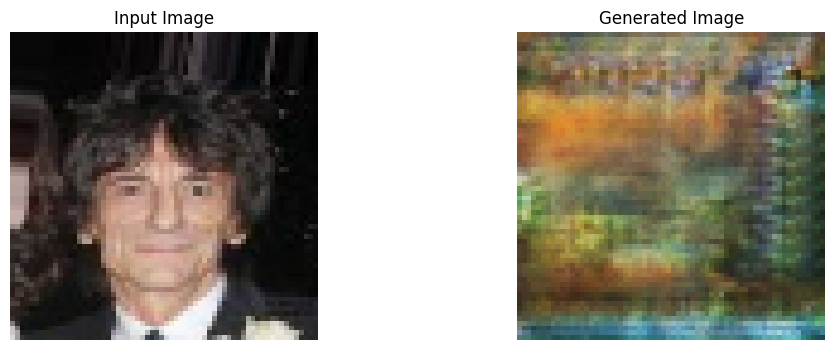

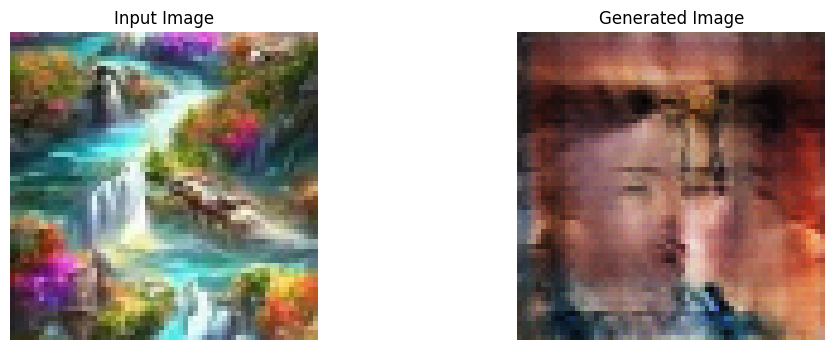

In [21]:
try:
    print("Loading datasets...")
    face_dataset, painting_dataset = load_dataset(
        config.CELEBA_PATH,
        config.PAINTINGS_PATH,
        config.BATCH_SIZE
    )

    print("Starting training...")
    history = train_cyclegan(face_dataset, painting_dataset, config.EPOCHS)

except Exception as e:
    print(f"Error during training: {e}")
    print("Make sure you have prepared the datasets in the correct directories:")
    print(f"- CelebA faces in: {config.CELEBA_PATH}")
    print(f"- Painting images in: {config.PAINTINGS_PATH}")


#Model Loading and Single Image Inference

In [22]:
def load_trained_model(epoch):
    """Load trained model weights"""
    generator_g.load_weights(f"{config.CHECKPOINT_PATH}/gen_g_epoch_{epoch}.weights.h5")
    generator_f.load_weights(f"{config.CHECKPOINT_PATH}/gen_f_epoch_{epoch}.weights.h5")
    print(f"Loaded model weights from epoch {epoch}")

def convert_face_to_painting(image_path):
    """Convert a single face image to painting style"""
    image = preprocess_image(image_path)
    image = tf.expand_dims(image, 0)
    painting = generator_g(image, training=False)
    generate_images(generator_g, image)
    return painting

def convert_painting_to_face(image_path):
    """Convert a painting to face style"""
    image = preprocess_image(image_path)
    image = tf.expand_dims(image, 0)
    face = generator_f(image, training=False)
    generate_images(generator_f, image)
    return face


#Evaluation and Plotting Training History

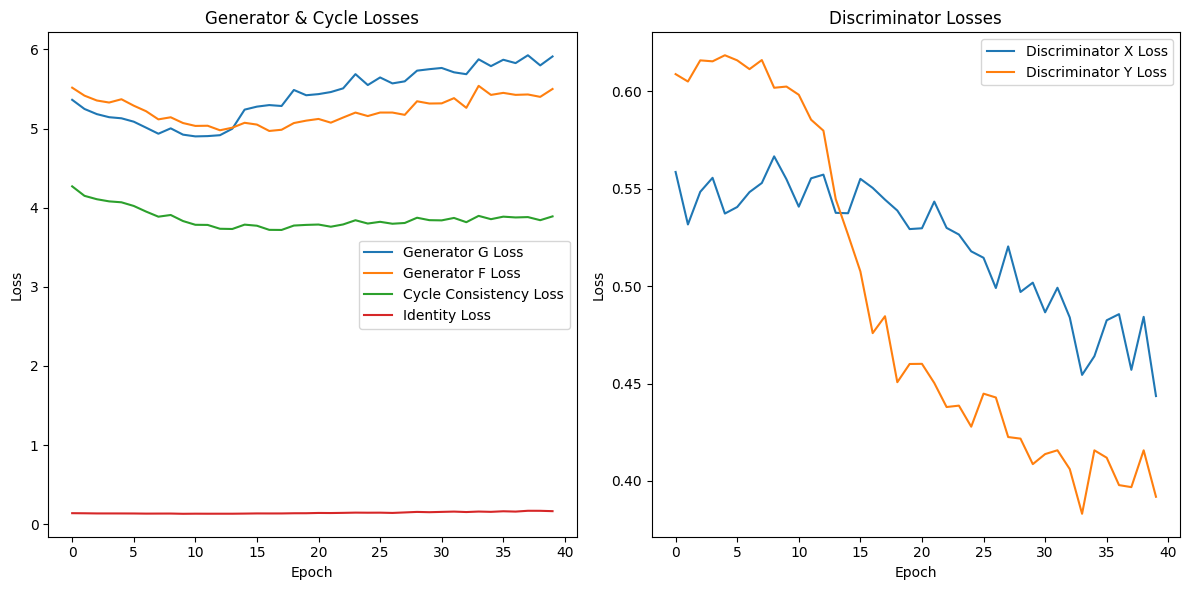

In [23]:
def evaluate_model(test_face_dataset, test_painting_dataset, num_samples=5):
    """Evaluate the trained model"""
    print("Evaluating model...")

    print("Face to Painting conversions:")
    for i, face_batch in enumerate(test_face_dataset.take(num_samples)):
        painting = generator_g(face_batch, training=False)
        generate_images(generator_g, face_batch,
                        f"evaluation/face_to_painting_{i}.png")

    print("Painting to Face conversions:")
    for i, painting_batch in enumerate(test_painting_dataset.take(num_samples)):
        face = generator_f(painting_batch, training=False)
        generate_images(generator_f, painting_batch,
                        f"evaluation/painting_to_face_{i}.png")

def plot_training_history(history):
    """Plot the losses over training epochs"""
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history['gen_g_loss'], label='Generator G Loss')
    plt.plot(history['gen_f_loss'], label='Generator F Loss')
    plt.plot(history['cycle_loss'], label='Cycle Consistency Loss')
    plt.plot(history['identity_loss'], label='Identity Loss')
    plt.title("Generator & Cycle Losses")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['disc_x_loss'], label='Discriminator X Loss')
    plt.plot(history['disc_y_loss'], label='Discriminator Y Loss')
    plt.title("Discriminator Losses")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.savefig("loss_plot.png")
    plt.show()

# Call to plot after training
plot_training_history(history)
